In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import numpy as np
import glob
import shutil
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:

def set_seed(seed: int = 42) -> None:
  random.seed(seed)
  np.random.seed(seed)
  tf.random.set_seed(seed)
  tf.experimental.numpy.random.seed(seed)
  tf.keras.utils.set_random_seed(seed)
  # When running on the CuDNN backend, two further options must be set
  os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
  os.environ['TF_DETERMINISTIC_OPS'] = '1'
  # Set a fixed value for the hash seed
  os.environ["PYTHONHASHSEED"] = str(seed)
  print(f"Random seed set as {seed}")
set_seed(42)


Random seed set as 42


In [3]:
_URL = "https://github.com/OROHealth/ace-it/raw/main/data_3class_skin_diseases.zip"
zip_file = tf.keras.utils.get_file(origin=_URL, 
                                   fname="data_3class_skin_diseases.zip", 
                                   extract=True)

base_dir = os.path.join(os.path.dirname(zip_file), 'data_3class_skin_diseases')

12285702/12285702 [==============================] - 0s 0us/step


In [4]:
classes = ["acne","herpes_simplex","lichen_planus"]

#Data Loading,Preprocessing and Augmentation

In [5]:
for cl in classes:
  img_path = os.path.join(base_dir, cl)
  images = glob.glob(img_path + '/*.jpg')
  print("{}: {} Images".format(cl, len(images)))
  num_train = int(round(len(images)*0.8))               # 80-20 split to train and dev set
  #train, val = images[:13], images[13:16]              # Using this for undersampling the data to 16 images per class
  train,val = images[:num_train], images[num_train:]    # Using the data as is
  for t in train:
    if not os.path.exists(os.path.join(base_dir, 'train', cl)):
      os.makedirs(os.path.join(base_dir, 'train', cl))
    shutil.move(t, os.path.join(base_dir, 'train', cl))

  for v in val:
    if not os.path.exists(os.path.join(base_dir, 'val', cl)):
      os.makedirs(os.path.join(base_dir, 'val', cl))
    shutil.move(v, os.path.join(base_dir, 'val', cl))

acne: 40 Images
herpes_simplex: 16 Images
lichen_planus: 46 Images


In [6]:
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

In [7]:
batch_size = 16
IMG_SHAPE = 224 

In [8]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()
    

In [9]:
#Data Augmentation
image_gen_train = ImageDataGenerator(
                    rescale=1./255, 
                    rotation_range=45, 
                    width_shift_range=.15, 
                    height_shift_range=.15, 
                    horizontal_flip=True, 
                    zoom_range=0.5,
                    )
train_data_gen = image_gen_train.flow_from_directory(
                                                batch_size=batch_size, 
                                                directory=train_dir, 
                                                shuffle=True, 
                                                target_size=(IMG_SHAPE,IMG_SHAPE),
                                                class_mode='sparse',
                                                seed=42
                                                )

Found 82 images belonging to 3 classes.


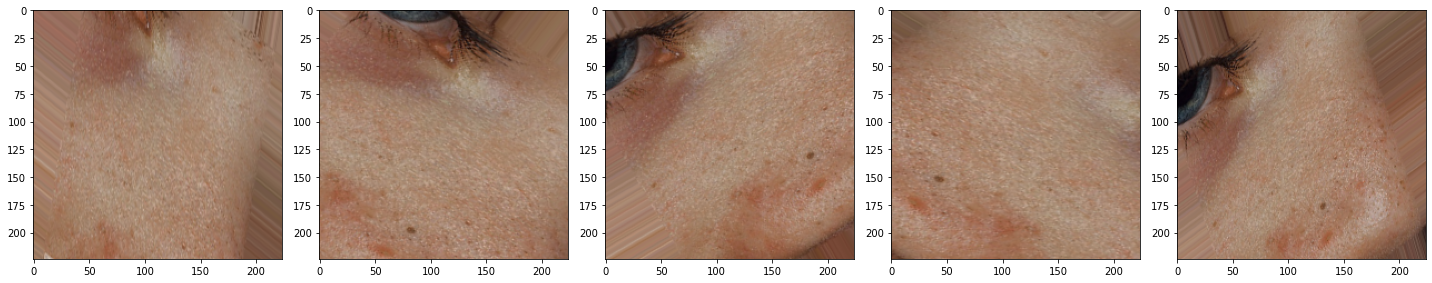

In [10]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [11]:
image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size, 
                                                 directory=val_dir, 
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='sparse',shuffle=False,seed=42)

Found 20 images belonging to 3 classes.


# Fine-tuning MobileNetV2 with Focal Sparse cross-entropy Loss on Unbalanced Data(Version 1)

In [12]:
!pip install focal-loss

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from sklearn.utils import class_weight 
import focal_loss

base_model = tf.keras.applications.MobileNetV2(input_shape=(IMG_SHAPE,IMG_SHAPE,3),
                                              include_top=False,
                                              weights='imagenet')
for layer in base_model.layers[:-3]:
  layer.trainable = False

class_weights = class_weight.compute_class_weight(
           'balanced',classes=np.unique(train_data_gen.classes),y=train_data_gen.classes) # identifying the class weights using sklearn
model = tf.keras.Sequential([
                          base_model,
                          tf.keras.layers.GlobalAveragePooling2D(),
                          tf.keras.layers.Dense(3, activation='softmax')])
model.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=3e-4,
    beta_1=0.9,
    beta_2=0.999),loss=focal_loss.SparseCategoricalFocalLoss(gamma=4,class_weight=class_weights,from_logits=False),metrics=['accuracy'])
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="mobilenet_tf_model_ft_cw/",
                                                 save_weights_only=True,
                                                 verbose=1)
es_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=4)

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
epochs = 100
# Use early stopping, LR scheduler
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(train_data_gen.n / float(batch_size))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(val_data_gen.n / float(batch_size))),
    callbacks=[cp_callback,es_callback],
    #class_weight = dict(enumerate(class_weights)) #Adding class_weights
)

<ipython-input-14-66780b11d101>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/100
6/6 [==============================] - ETA: 0s - loss: 0.4925 - accuracy: 0.3171
Epoch 1: saving model to mobilenet_tf_model_ft_cw/
6/6 [==============================] - 16s 736ms/step - loss: 0.4925 - accuracy: 0.3171 - val_loss: 0.2886 - val_accuracy: 0.5000
Epoch 2/100
6/6 [==============================] - ETA: 0s - loss: 0.2058 - accuracy: 0.6098
Epoch 2: saving model to mobilenet_tf_model_ft_cw/
6/6 [==============================] - 2s 317ms/step - loss: 0.2058 - accuracy: 0.6098 - val_loss: 0.5051 - val_accuracy: 0.5500
Epoch 3/100
6/6 [==============================] - ETA: 0s - loss: 0.1700 - accuracy: 0.6829
Epoch 3: saving model to mobilenet_tf_model_ft_cw/
6/6 [==============================] - 2s 373ms/step - loss: 0.1700 - accuracy: 0.6829 - val_loss: 0.5295 - val_accuracy: 0.6000
Epoch 4/100
6/6 [==============================] - ETA: 0s - loss: 0.1579 - accuracy: 0.7927
Epoch 4: saving model to mobilenet_tf_model_ft_cw/
6/6 [==============================]

In [ ]:
from sklearn.metrics import classification_report
val_data_gen.reset()
predictions = np.argmax(model.predict(val_data_gen,val_data_gen.samples/val_data_gen.batch_size, workers=0),axis=1)
labels = val_data_gen.labels
print(classification_report(labels, predictions, target_names=classes))

2/2 [==============================] - 1s 102ms/step
                precision    recall  f1-score   support

          acne       0.62      1.00      0.76         8
herpes_simplex       0.67      0.67      0.67         3
 lichen_planus       1.00      0.44      0.62         9

      accuracy                           0.70        20
     macro avg       0.76      0.70      0.68        20
  weighted avg       0.80      0.70      0.68        20



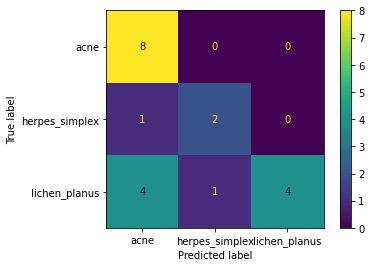

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classes)
disp.plot()
plt.show()

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
def ROC_AUC(y,y_prob):
    # calculate roc curves
    fpr, tpr, threshold = roc_curve(y, y_prob)
    # calculate scores
    model_auc = roc_auc_score(y, y_prob)
    
    # plot the roc curve for the model
    plt.plot([0,1], [0,1], linestyle='--', label='Random Classifier Baseline - AUC=0.5' )
    plt.plot(fpr, tpr, marker='.', label='Model - AUC=%.3f' %  (model_auc))
    
    # show axis labels and the legend
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid(True)
    plt.show(block=False)
    return

In [ ]:
roc_auc_score(labels,model.predict(val_data_gen,val_data_gen.samples/val_data_gen.batch_size, workers=0),multi_class='ovo')

2/2 [==============================] - 0s 96ms/step


0.8935185185185185

In [ ]:
model.save("mobilenet")

In [12]:
!unzip mobilenet.zip

Archive:  mobilenet.zip
   creating: content/mobilenet/
   creating: content/mobilenet/variables/
  inflating: content/mobilenet/variables/variables.data-00000-of-00001  
  inflating: content/mobilenet/variables/variables.index  
  inflating: content/mobilenet/keras_metadata.pb  
   creating: content/mobilenet/assets/
  inflating: content/mobilenet/saved_model.pb  


In [13]:
mnet_model = tf.keras.models.load_model("/content/content/mobilenet", compile=False)

In [14]:
from sklearn.metrics import classification_report
val_data_gen.reset()
predictions = np.argmax(mnet_model.predict(val_data_gen,val_data_gen.samples/val_data_gen.batch_size, workers=0),axis=1)
labels = val_data_gen.labels
print(classification_report(labels, predictions, target_names=classes))

2/2 [==============================] - 9s 320ms/step
                precision    recall  f1-score   support

          acne       0.62      1.00      0.76         8
herpes_simplex       0.67      0.67      0.67         3
 lichen_planus       1.00      0.44      0.62         9

      accuracy                           0.70        20
     macro avg       0.76      0.70      0.68        20
  weighted avg       0.80      0.70      0.68        20



In [ ]:
!zip -r /content/mobilenet.zip /content/mobilenet

  adding: content/mobilenet/ (stored 0%)
  adding: content/mobilenet/variables/ (stored 0%)
  adding: content/mobilenet/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/mobilenet/variables/variables.index (deflated 76%)
  adding: content/mobilenet/keras_metadata.pb (deflated 96%)
  adding: content/mobilenet/assets/ (stored 0%)
  adding: content/mobilenet/saved_model.pb (deflated 91%)


In [ ]:
from google.colab import files
files.download("/content/mobilenet.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Fine-tuning MobileNetV2 with Focal Sparse cross-entropy Loss on Unbalanced Data(Version 2)

In [ ]:
!pip install focal-loss

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from sklearn.utils import class_weight 
import focal_loss

base_model = tf.keras.applications.MobileNetV2(input_shape=(IMG_SHAPE,IMG_SHAPE,3),
                                              include_top=False,
                                              weights='imagenet')
for layer in base_model.layers[:-3]:
  layer.trainable = False

class_weights = class_weight.compute_class_weight(
           'balanced',classes=np.unique(train_data_gen.classes),y=train_data_gen.classes) # identifying the class weights using sklearn
model = tf.keras.Sequential([
                          base_model,
                          tf.keras.layers.GlobalAveragePooling2D(),
                          tf.keras.layers.Dense(3, activation='softmax')])
model.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=3e-4,
    beta_1=0.9,
    beta_2=0.999),loss=focal_loss.SparseCategoricalFocalLoss(gamma=4,class_weight=class_weights,from_logits=False),metrics=['accuracy'])
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="mobilenet_tf_model_ft_cw/",
                                                 save_weights_only=True,
                                                 verbose=1)
es_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=4)

In [ ]:
model.load_weights("/content/mobilenet_tf_model_ft_cw/")

In [ ]:
epochs = 100
# Use early stopping, LR scheduler
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(train_data_gen.n / float(batch_size))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(val_data_gen.n / float(batch_size))),
    callbacks=[cp_callback,es_callback],
    #class_weight = dict(enumerate(class_weights)) #Adding class_weights
)

<ipython-input-42-66780b11d101>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/100
6/6 [==============================] - ETA: 0s - loss: 0.4792 - accuracy: 0.3659
Epoch 1: saving model to mobilenet_tf_model_ft_cw/
6/6 [==============================] - 13s 2s/step - loss: 0.4792 - accuracy: 0.3659 - val_loss: 0.5445 - val_accuracy: 0.5000
Epoch 2/100
5/6 [========================>.....] - ETA: 0s - loss: 0.2200 - accuracy: 0.5875
Epoch 2: saving model to mobilenet_tf_model_ft_cw/
6/6 [==============================] - 2s 306ms/step - loss: 0.2202 - accuracy: 0.5854 - val_loss: 0.2896 - val_accuracy: 0.6500
Epoch 3/100
6/6 [==============================] - ETA: 0s - loss: 0.1909 - accuracy: 0.6585
Epoch 3: saving model to mobilenet_tf_model_ft_cw/
6/6 [==============================] - 2s 315ms/step - loss: 0.1909 - accuracy: 0.6585 - val_loss: 0.2105 - val_accuracy: 0.7500
Epoch 4/100
6/6 [==============================] - ETA: 0s - loss: 0.0997 - accuracy: 0.7683
Epoch 4: saving model to mobilenet_tf_model_ft_cw/
6/6 [==============================] - 

In [ ]:
val_data_gen.reset()
preds = np.argmax(model.predict(val_data_gen,val_data_gen.samples/val_data_gen.batch_size, workers=0),axis=1)
labels = val_data_gen.labels

2/2 [==============================] - 0s 111ms/step


In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(labels,preds)

0.8

In [ ]:
from sklearn.metrics import classification_report
val_data_gen.reset()
predictions = np.argmax(model.predict(val_data_gen,val_data_gen.samples/val_data_gen.batch_size, workers=0),axis=1)
labels = val_data_gen.labels
print(classification_report(labels, predictions, target_names=classes))

2/2 [==============================] - 0s 151ms/step
                precision    recall  f1-score   support

          acne       0.88      0.88      0.88         8
herpes_simplex       0.67      0.67      0.67         3
 lichen_planus       0.78      0.78      0.78         9

      accuracy                           0.80        20
     macro avg       0.77      0.77      0.77        20
  weighted avg       0.80      0.80      0.80        20



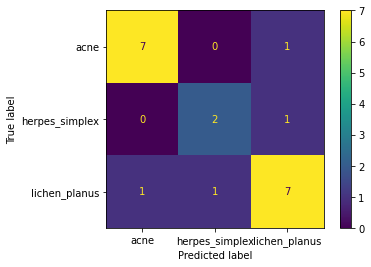

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classes)
disp.plot()
plt.show()

# Fine-tuning MobileNetV2 with Focal Sparse cross-entropy Loss on Unbalanced Data with LR Scheduler

In [ ]:
from sklearn.utils import class_weight 
import focal_loss

base_model = tf.keras.applications.MobileNetV2(input_shape=(IMG_SHAPE,IMG_SHAPE,3),
                                              include_top=False,
                                              weights='imagenet')
for layer in base_model.layers[:-3]:
  layer.trainable = False

class_weights = class_weight.compute_class_weight(
           'balanced',classes=np.unique(train_data_gen.classes),y=train_data_gen.classes) # identifying the class weights using sklearn
model = tf.keras.Sequential([
                          base_model,
                          tf.keras.layers.GlobalAveragePooling2D(),
                          tf.keras.layers.Dense(3, activation='softmax')])
initial_learning_rate=0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=50000,
    decay_rate=0.96,
    staircase=True)
model.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=lr_schedule,
    beta_1=0.9,
    beta_2=0.999),loss=focal_loss.SparseCategoricalFocalLoss(gamma=4,class_weight=class_weights,from_logits=False),metrics=['accuracy'])
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="mobilenet_tf_model_ft_cw/",
                                                 save_weights_only=True,
                                                 verbose=1)
es_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=4)

In [ ]:
epochs = 50
# Use early stopping, LR scheduler
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(train_data_gen.n / float(batch_size))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(val_data_gen.n / float(batch_size))),
    callbacks=[cp_callback,es_callback],
    #class_weight = dict(enumerate(class_weights)) #Adding class_weights
)

<ipython-input-108-155ce0fbb5b7>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/50
5/6 [========================>.....] - ETA: 0s - loss: 0.4722 - accuracy: 0.3000
Epoch 1: saving model to mobilenet_tf_model_ft_cw/
6/6 [==============================] - 7s 582ms/step - loss: 0.4630 - accuracy: 0.3049 - val_loss: 0.4402 - val_accuracy: 0.4000
Epoch 2/50
5/6 [========================>.....] - ETA: 0s - loss: 0.2506 - accuracy: 0.4250
Epoch 2: saving model to mobilenet_tf_model_ft_cw/
6/6 [==============================] - 2s 325ms/step - loss: 0.2491 - accuracy: 0.4146 - val_loss: 0.3076 - val_accuracy: 0.4500
Epoch 3/50
6/6 [==============================] - ETA: 0s - loss: 0.2378 - accuracy: 0.5732
Epoch 3: saving model to mobilenet_tf_model_ft_cw/
6/6 [==============================] - 2s 322ms/step - loss: 0.2378 - accuracy: 0.5732 - val_loss: 0.2733 - val_accuracy: 0.5500
Epoch 4/50
6/6 [==============================] - ETA: 0s - loss: 0.1464 - accuracy: 0.6585
Epoch 4: saving model to mobilenet_tf_model_ft_cw/
6/6 [==============================] - 2s

In [ ]:
from sklearn.metrics import classification_report
val_data_gen.reset()
predictions = np.argmax(model.predict(val_data_gen,val_data_gen.samples/val_data_gen.batch_size, workers=0),axis=1)
labels = val_data_gen.labels
print(classification_report(labels, predictions, target_names=classes))

2/2 [==============================] - 1s 103ms/step
                precision    recall  f1-score   support

          acne       0.50      0.88      0.64         8
herpes_simplex       0.33      0.33      0.33         3
 lichen_planus       0.67      0.22      0.33         9

      accuracy                           0.50        20
     macro avg       0.50      0.48      0.43        20
  weighted avg       0.55      0.50      0.45        20



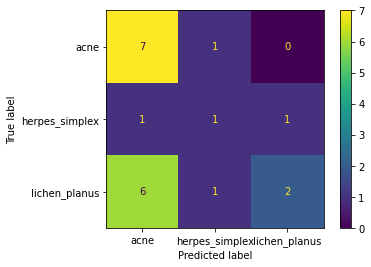

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classes)
disp.plot()
plt.show()

#Fine-tuning EfficientNet with Focal Sparse cross-entropy Loss on Unbalanced Data

In [ ]:
base_model = tf.keras.applications.efficientnet.EfficientNetB0(input_shape=(IMG_SHAPE,IMG_SHAPE,3),
    include_top=False,
    weights='imagenet')
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 224, 224, 3)  0           ['input_12[0][0]']               
                                                                                                  
 normalization_2 (Normalization  (None, 224, 224, 3)  7          ['rescaling_2[0][0]']            
 )                                                                                                
                                                                                     

In [ ]:
for layer in base_model.layers[:-3]:
  layer.trainable = False

In [ ]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="efficientnet_tf_model/",
                                                 save_weights_only=True,
                                                 verbose=1)
class_weights = class_weight.compute_class_weight(
           'balanced',classes=np.unique(train_data_gen.classes),y=train_data_gen.classes) # identifying the class weights using sklearn
model = tf.keras.Sequential([
                          base_model,
                          tf.keras.layers.GlobalAveragePooling2D(),
                          tf.keras.layers.Dense(3, activation='softmax')])
model.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=3e-4,
    beta_1=0.9,
    beta_2=0.999),loss=focal_loss.SparseCategoricalFocalLoss(gamma=4,class_weight=class_weights,from_logits=False),metrics=['accuracy'])
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="efficientnet_tf_model_ft_cw/",
                                                 save_weights_only=True,
                                                 verbose=1)
es_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=4)

In [ ]:
epochs = 50
# Use early stopping, LR scheduler
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(train_data_gen.n / float(batch_size))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(val_data_gen.n / float(batch_size))),
    callbacks=[cp_callback,es_callback],
    #class_weight = dict(enumerate(class_weights)) #Adding class_weights
)

<ipython-input-95-155ce0fbb5b7>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/50
6/6 [==============================] - ETA: 0s - loss: 0.2215 - accuracy: 0.3293
Epoch 1: saving model to efficientnet_tf_model_ft_cw/
6/6 [==============================] - 10s 631ms/step - loss: 0.2215 - accuracy: 0.3293 - val_loss: 0.2431 - val_accuracy: 0.1500
Epoch 2/50
6/6 [==============================] - ETA: 0s - loss: 0.3092 - accuracy: 0.4390
Epoch 2: saving model to efficientnet_tf_model_ft_cw/
6/6 [==============================] - 2s 345ms/step - loss: 0.3092 - accuracy: 0.4390 - val_loss: 0.2389 - val_accuracy: 0.1500
Epoch 3/50
6/6 [==============================] - ETA: 0s - loss: 0.2366 - accuracy: 0.2439
Epoch 3: saving model to efficientnet_tf_model_ft_cw/
6/6 [==============================] - 2s 334ms/step - loss: 0.2366 - accuracy: 0.2439 - val_loss: 0.2331 - val_accuracy: 0.4500
Epoch 4/50
6/6 [==============================] - ETA: 0s - loss: 0.2459 - accuracy: 0.2927
Epoch 4: saving model to efficientnet_tf_model_ft_cw/
6/6 [=======================

In [ ]:
from sklearn.metrics import classification_report
val_data_gen.reset()
predictions = np.argmax(model.predict(val_data_gen,val_data_gen.samples/val_data_gen.batch_size, workers=0),axis=1)
labels = val_data_gen.labels
print(classification_report(labels, predictions, target_names=classes))

2/2 [==============================] - 2s 118ms/step
                precision    recall  f1-score   support

          acne       0.00      0.00      0.00         8
herpes_simplex       0.00      0.00      0.00         3
 lichen_planus       0.45      1.00      0.62         9

      accuracy                           0.45        20
     macro avg       0.15      0.33      0.21        20
  weighted avg       0.20      0.45      0.28        20



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


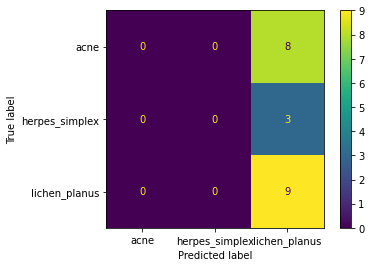

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classes)
disp.plot()
plt.show()

# Fine-tuning ResNet50 with Focal Sparse cross-entropy Loss on Unbalanced Data

In [ ]:
base_model = tf.keras.applications.resnet50.ResNet50(input_shape=(IMG_SHAPE,IMG_SHAPE,3),
                                              include_top=False,
                                              weights='imagenet')

In [ ]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_9[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
for layer in base_model.layers[:-4]:
  layer.trainable = False

In [ ]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="resnet50_tf_model/",
                                                 save_weights_only=True,
                                                 verbose=1)
class_weights = class_weight.compute_class_weight(
           'balanced',classes=np.unique(train_data_gen.classes),y=train_data_gen.classes) # identifying the class weights using sklearn
model = tf.keras.Sequential([
                          base_model,
                          tf.keras.layers.GlobalAveragePooling2D(),
                          tf.keras.layers.Dense(3, activation='softmax')])
model.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=3e-4,
    beta_1=0.9,
    beta_2=0.999),loss=focal_loss.SparseCategoricalFocalLoss(gamma=4,class_weight=class_weights,from_logits=False),metrics=['accuracy'])
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="resnet_tf_model_ft_cw/",
                                                 save_weights_only=True,
                                                 verbose=1)
es_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=4)

In [ ]:
epochs = 50
# Use early stopping, LR scheduler
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(train_data_gen.n / float(batch_size))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(val_data_gen.n / float(batch_size))),
    callbacks=[cp_callback,es_callback],
    #class_weight = dict(enumerate(class_weights)) #Adding class_weights
)

<ipython-input-82-155ce0fbb5b7>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/50
5/6 [========================>.....] - ETA: 0s - loss: 0.4317 - accuracy: 0.3625
Epoch 1: saving model to resnet_tf_model_ft_cw/
6/6 [==============================] - 7s 653ms/step - loss: 0.4239 - accuracy: 0.3659 - val_loss: 0.5555 - val_accuracy: 0.1500
Epoch 2/50
6/6 [==============================] - ETA: 0s - loss: 0.2752 - accuracy: 0.2561
Epoch 2: saving model to resnet_tf_model_ft_cw/
6/6 [==============================] - 3s 475ms/step - loss: 0.2752 - accuracy: 0.2561 - val_loss: 0.5526 - val_accuracy: 0.1500
Epoch 3/50
6/6 [==============================] - ETA: 0s - loss: 0.2331 - accuracy: 0.3780
Epoch 3: saving model to resnet_tf_model_ft_cw/
6/6 [==============================] - 2s 390ms/step - loss: 0.2331 - accuracy: 0.3780 - val_loss: 0.5154 - val_accuracy: 0.1500
Epoch 4/50
6/6 [==============================] - ETA: 0s - loss: 0.2339 - accuracy: 0.4024
Epoch 4: saving model to resnet_tf_model_ft_cw/
6/6 [==============================] - 2s 448ms/step 

In [ ]:
from sklearn.metrics import classification_report
val_data_gen.reset()
predictions = np.argmax(model.predict(val_data_gen,val_data_gen.samples/val_data_gen.batch_size, workers=0),axis=1)
labels = val_data_gen.labels
print(classification_report(labels, predictions, target_names=classes))

2/2 [==============================] - 1s 133ms/step
                precision    recall  f1-score   support

          acne       0.40      1.00      0.57         8
herpes_simplex       0.00      0.00      0.00         3
 lichen_planus       0.00      0.00      0.00         9

      accuracy                           0.40        20
     macro avg       0.13      0.33      0.19        20
  weighted avg       0.16      0.40      0.23        20



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


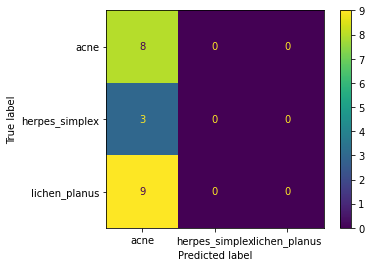

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classes)
disp.plot()
plt.show()